In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/Colab Notebooks/deep-learning-group"

/content/drive/My Drive/Colab Notebooks/deep-learning-group


In [0]:
import autoreload
%load_ext autoreload

In [0]:
%reload_ext autoreload

In [0]:
import glob
import cv2
import numpy as np
import os


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import csv
import helpers
import pandas as pd
import split_utils

In [52]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset'

batch_size_train = 200
val_size_train = 30
batch_size = 32

colorMode = 'rgb'
classMode = "categorical"
imgSize = 64

base_dir, train_dir, test_dir = split_utils.train_valid_split(DATA_DIR, 0.1, seed=1)

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             rescale=1./255,
                             zoom_range=0.3,
                             validation_split=0.11,
                             horizontal_flip=True)

train_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='training')

validation_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='validation')

Found 1042 images belonging to 17 classes.
Found 119 images belonging to 17 classes.


**Callback functions list**

In [0]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0.001,
                           patience=5)

**Simple CNN model**

In [0]:
cvsores_1 = []
filepath_1 = "Weights_1.best.hdf5"
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

logpath_1 = "Model_1_history.csv"
log_1 = CSVLogger(logpath_1, append=True)

callback_list_1 = [early_stop, checkpoint_1, log_1]

def get_compiled_model_1(optimizer='adam', loss='categorical_crossentropy'):
  keras.backend.clear_session()
  model = Sequential([
                      Conv2D(32, activation='relu', kernel_size=3, input_shape=(imgSize, imgSize, 3)),
                      MaxPooling2D(pool_size=(2, 2)),
                      Conv2D(32, activation='relu', kernel_size=3),
                      MaxPooling2D(pool_size=(2, 2)),
                      Flatten(),
                      Dense(128, activation='relu'),
                      Dense(17, activation='softmax')
  ])
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [12]:
#@title Default title text
model_1 = get_compiled_model_1()

history = model_1.fit_generator(train_generator,
            steps_per_epoch=200,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=100,
            callbacks=callback_list_1)

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


200/200 [==============================] - ETA: 0s - loss: 1.7919 - accuracy: 0.4470
Epoch 00001: val_accuracy improved from -inf to 0.55395, saving model to Weights_1.best.hdf5
200/200 [==============================] - 332s 2s/step - loss: 1.7919 - accuracy: 0.4470 - val_loss: 1.4812 - val_accuracy: 0.5539
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 1.1145 - accuracy: 0.6476
Epoch 00002: val_accuracy improved from 0.55395 to 0.60849, saving model to Weights_1.best.hdf5
200/200 [==============================] - 281s 1s/step - loss: 1.1145 - accuracy: 0.6476 - val_loss: 1.3091 - val_accuracy: 0.6085
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.8566 - accuracy: 0.7226
Epoch 00003: val_accuracy improved from 0.60849 to 0.61992, saving model to Weights_1.best.hdf5
200/200 [==============================] - 278s 1s/step - loss: 0.8566 - accuracy: 0.7226 - val_loss: 1.3287 - val_accuracy: 0.6199
Epoch 4/30
200/200 [======================

KeyboardInterrupt: ignored

![alt text](https://)

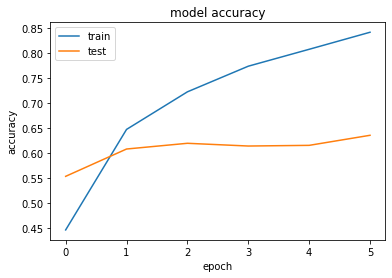

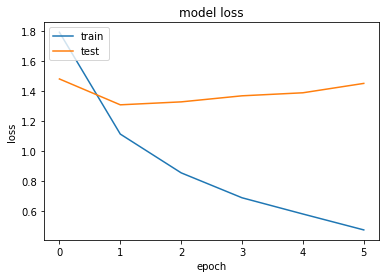

In [28]:
log_data = pd.read_csv(logpath_1)
helpers.plotTrainingHistory(log_data)

In [30]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 17)                2

In [0]:
del testgen

In [0]:
del test_generator


In [82]:
testgen = ImageDataGenerator(rescale=1./255)

test_generator = testgen.flow_from_directory(test_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size,
                                            shuffle=False)

y_pred = model_1.predict_generator(test_generator, steps = test_generator.samples//batch_size+1, verbose=1)

Found 137 images belonging to 17 classes.
2/5 [===========>..................] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


5/5 [==============================] - 0s 96ms/step


In [94]:
test_generator.class_indices.keys()

dict_keys(['adho mukha svanasana', 'ardha matsyendrasana', 'astavakrasana', 'baddha konasana', 'bakasana', 'balasana', 'bhujangasana', 'bitilasana', 'chakravakasana', 'chaturanga dandasana', 'garudasana', 'gomukhasana', 'natarajasana', 'supta baddha konasana', 'ustrasana', 'utkatasana', 'vasisthasana'])

In [0]:
le = LabelEncoder()
listLabel = list(test_generator.class_indices.keys())
le.fit(listLabel)
encodedLabel = le.transform(listLabel)

In [111]:
y_pred = np.argmax(y_pred, axis=1)

AxisError: ignored

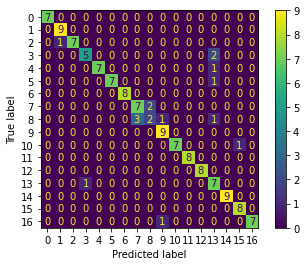

In [112]:

# y_true = np.argmax()
ConfusionMatrixDisplay(confusion_matrix(test_generator.classes, y_pred), encodedLabel).plot()

**Simple model using transfer learning**

In [0]:
cvscores_2 = []
def get_compiled_model_2():
  keras.backend.clear_seesion()
  baseModel = VGG16(weights='imagenet',
                    include_top=False,
                    input_tensor=Input(shape=(imgSize, imgSize, 3)))
  
  for layer in baseModel.layers[:-5]:
    layer.trainable = False
  
  